In [11]:
import pandas as pd
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import os
import numpy

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
X_fileName = []
y_val = []

In [14]:
for fileName in sorted(glob.iglob('train/**/**', recursive=False)):
    X_fileName.append(fileName)
    y_val.append(fileName.split("\\")[-2])

In [15]:
myDf = pd.DataFrame()
myDf['fileName'] = X_fileName
myDf['label'] = y_val

In [16]:
myLabelEncoder = LabelEncoder()
myDf['label_val'] = myLabelEncoder.fit_transform(myDf['label'])

In [17]:
def pointremove(image):
    
    img=image.copy()
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=4)
    sizes = stats[:, -1]
    for i in range(1, nb_components):
        if sizes[i]<100 :
            img[output==i]=0
    return img

In [18]:
def maxmeanpreprop(path):
    img1 = cv2.imread(path)
    g_img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img = g_img.copy()
    ret1,th1 = cv2.threshold(g_img,40,255,cv2.THRESH_BINARY)
    th1=pointremove(th1)
    blur = cv2.GaussianBlur(th1,(5,5),0)
    ret2,th2 = cv2.threshold(blur,130,255,cv2.THRESH_OTSU)

    a_img=th2&img
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(a_img, connectivity=4)
    sizes = stats[:, -1]

    max_label = 0
    max_mean = 0

    for i in range(1, nb_components):
        mean=np.mean(a_img[output==i])
        if mean > max_mean and sizes[i]>1000 :
            max_label = i
            max_mean = mean

    img3 = np.zeros(output.shape)
    img3[output == max_label] = 255
    new_image = img3[stats[max_label][1]:stats[max_label][1]+stats[max_label][3],stats[max_label][0]:stats[max_label][0]+stats[max_label][2]]
    image_for_input = cv2.resize(new_image, (100, 100), interpolation = cv2.INTER_NEAREST)
    return image_for_input

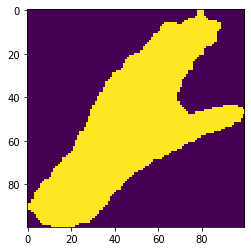

In [19]:
plt.imshow(maxmeanpreprop(myDf['fileName'][0]))

In [20]:
def my_generator(features, batch_size=16):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, 100, 100, 1))
    batch_labels = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # choose random index in features
            index = np.random.choice(len(features),1)
            batch_features[i] = maxmeanpreprop(features.loc[index[0]]['fileName']).reshape([100, 100, 1])
            batch_labels[i] = features.loc[index[0]]['label_val']
        yield batch_features, batch_labels

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K

Using TensorFlow backend.


In [22]:

def MyModel(input_shape):
    
    model = Sequential()

    model.add(Lambda(lambda x: x / 255 - 0.5, input_shape=input_shape))

    model.add(Conv2D(24, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(36, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(48, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    return model

In [23]:
myMod = MyModel([100, 100, 1])

C:\Users\akkir\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  import sys
C:\Users\akkir\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\akkir\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  del sys.path[0]
C:\Users\akkir\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  app.launch_new_instance()
C:\Users\akkir\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`


In [24]:
myMod.fit_generator(my_generator(myDf), samples_per_epoch=200, nb_epoch=5)

C:\Users\akkir\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
C:\Users\akkir\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=200, epochs=5)`
  """Entry point for launching an IPython kernel.


Epoch 1/5
200/200 [==============================] - 43s 217ms/step - loss: 23.6780 - accuracy: 0.0737
Epoch 2/5
200/200 [==============================] - 43s 214ms/step - loss: 18.8543 - accuracy: 0.0822
Epoch 3/5
200/200 [==============================] - 42s 208ms/step - loss: 16.9359 - accuracy: 0.0828
Epoch 4/5
200/200 [==============================] - 41s 204ms/step - loss: 15.9775 - accuracy: 0.0769
Epoch 5/5
200/200 [==============================] - 42s 211ms/step - loss: 15.4876 - accuracy: 0.0781
